In [1]:
import sys
sys.path.append('/content/drive/MyDrive/Deep/')

In [2]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from sklearn.metrics import classification_report, confusion_matrix,multilabel_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical,plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
from model import U_NET
import seaborn as sns
import numpy as np
import cv2

In [3]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/Car_Segmentation/Unet.keras')
model.save('/content/drive/MyDrive/Colab Notebooks/Car_Segmentation/Unet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Read images and labels data

In [4]:
images = np.load('/content/drive/MyDrive/Deep/images.npy')
labels = np.load('/content/drive/MyDrive/Deep/labels.npy')

print('Images size:',images.shape)
print('Labels size:',labels.shape)
print('Labels unique values:',np.unique(labels))

Images size: (500, 224, 224, 3)
Labels size: (500, 224, 224)
Labels unique values: [0 1 2 3 4 5]


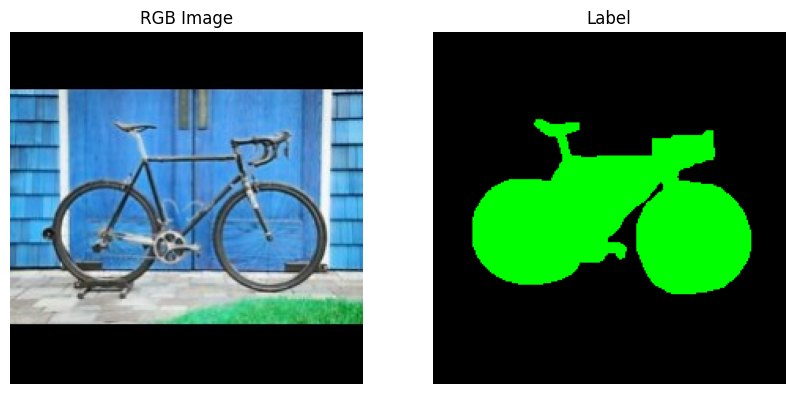

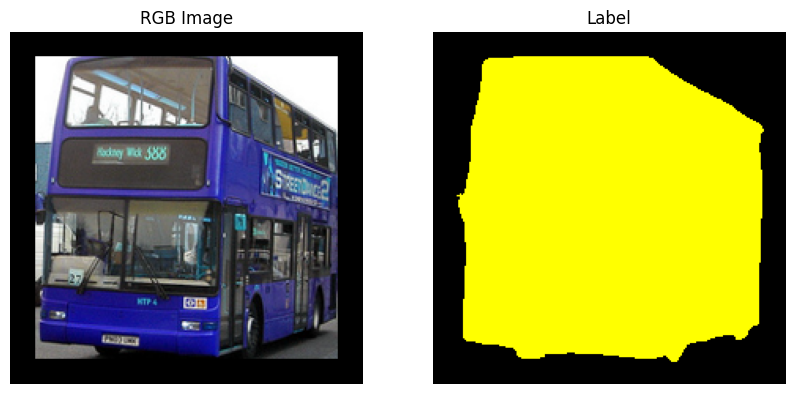

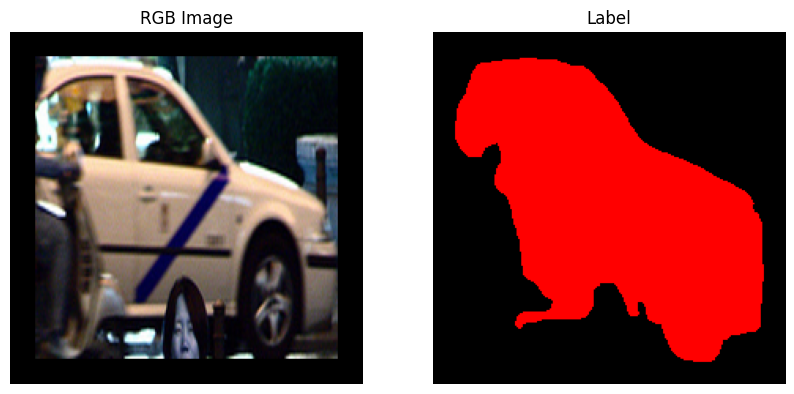

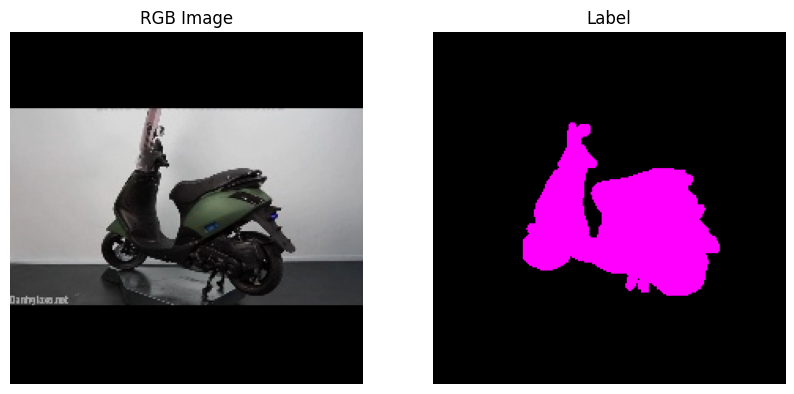

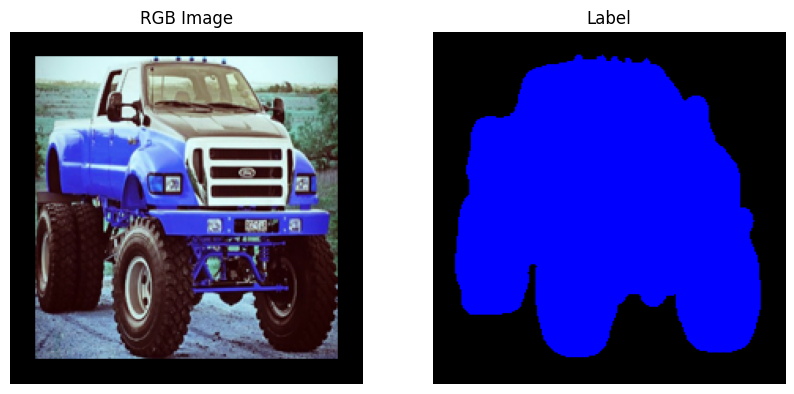

In [60]:
train_id_to_color = np.array([ ( 0, 0, 0),
                               ( 0, 255, 0),
                               (255, 255, 0),
                               ( 255, 0, 0),
                               ( 255, 0, 255),
                               ( 0, 0, 255),
]
)

for i in [84,184,203,311,480]:

  fig, axes = plt.subplots(1,2, figsize=(10, 5))
  index = i
  axes[0].imshow(images[index])
  axes[0].set_title("RGB Image")
  axes[0].axis('off')
  axes[1].imshow(train_id_to_color[labels[index]])
  axes[1].set_title("Label")
  axes[1].axis('off')

# Data preprocessing and splitting

In [5]:
def preprocessing(images, labels):
    # Convert labels to float32
    labels = labels.astype('float32')
    num_classes = 6
    # Normalize images to [0, 1]
    images = images.astype('float32') / 255.0

    # Train-Test Split
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=111)

    train_x = x_train
    train_y = y_train

    x_train = train_x[:301]
    y_train = train_y[:301]

    x_val = train_x[301:]
    y_val = train_y[301:]

    # Rotate images and labels
    rotation_angle = [90,180]  # Điều chỉnh góc xoay tùy ý
    for r in rotation_angle:
      x_rot = np.rot90(x_train, k=r // 90, axes=(1, 2))
      x_train = np.concatenate((x_train,x_rot),axis=0)
      y_rot = np.rot90(y_train, k=r // 90, axes=(1, 2))
      y_train = np.concatenate((y_train,y_rot),axis=0)

    # One-hot encode output mask
    train_masks = to_categorical(y_train, num_classes=num_classes)
    y_train = train_masks.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], num_classes))

    val_masks = to_categorical(y_val, num_classes=num_classes)
    y_val = val_masks.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], num_classes))



    print("Training x data shape is: {}".format(x_train.shape))
    print("Training y data shape is: {}".format(y_train.shape))
    print("Validation x data shape is: {}".format(x_val.shape))
    print("Validating y data shape is: {}".format(y_val.shape))
    print("Test x data shape is: {}".format(x_test.shape))
    print("Test y data shape is: {}".format(y_test.shape))

    return x_train, y_train, x_val, y_val, x_test, y_test
def tf_data(x_train, y_train, x_val, y_val, batch_size):
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
  val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return train_ds, val_ds

In [6]:
x_train, y_train, x_val, y_val, x_test, y_test = preprocessing(images, labels)

Training x data shape is: (1204, 224, 224, 3)
Training y data shape is: (1204, 224, 224, 6)
Validation x data shape is: (99, 224, 224, 3)
Validating y data shape is: (99, 224, 224, 6)
Test x data shape is: (100, 224, 224, 3)
Test y data shape is: (100, 224, 224)


# U-Net model training

In [8]:
model = U_NET(224,224,3,6)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

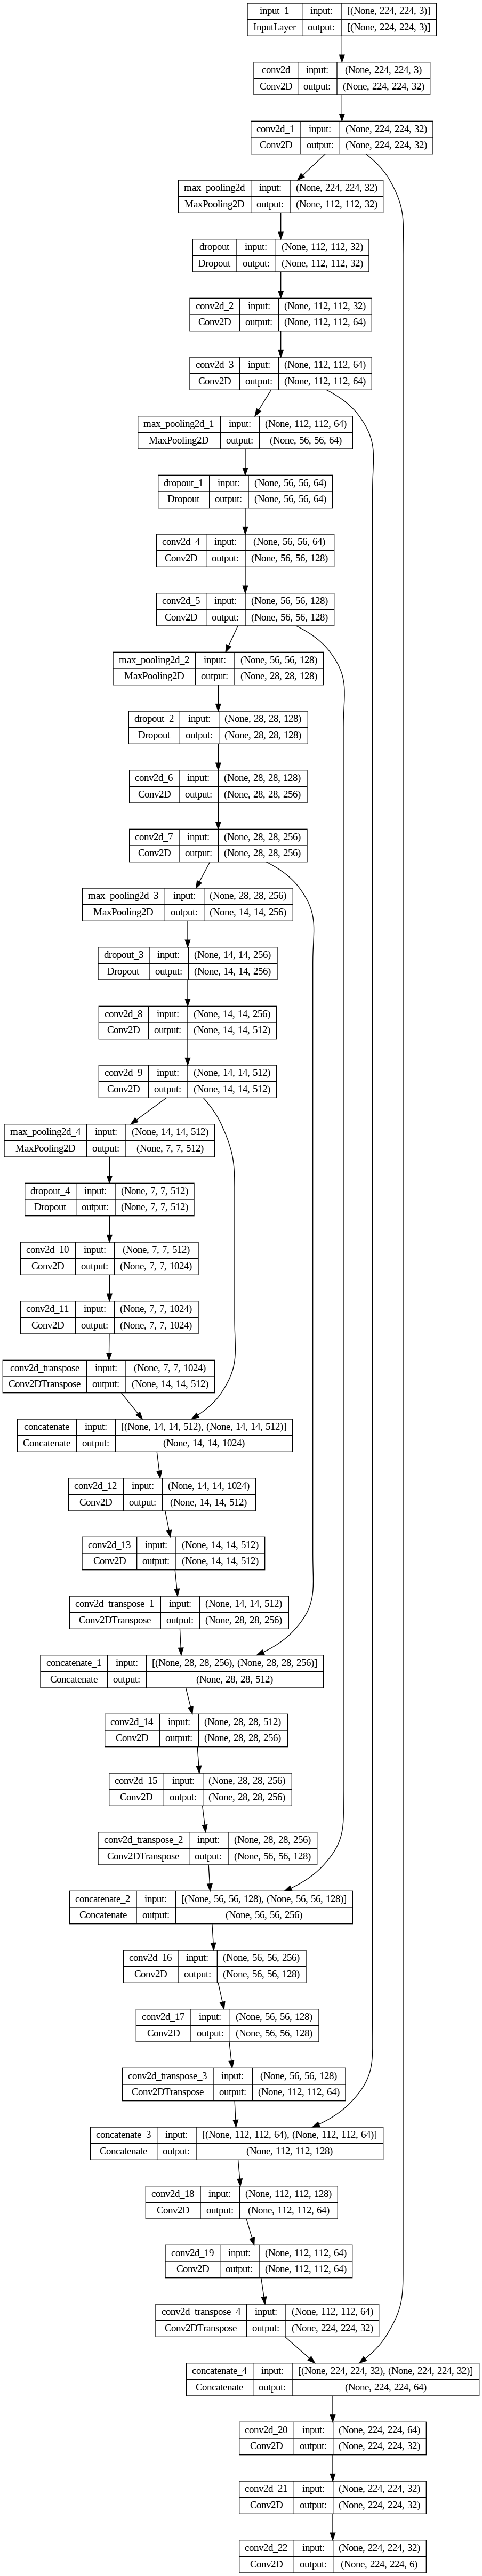

In [9]:
plot_model(model, show_shapes=True)

Epoch 1/50
121/121 [==============================] - 59s 300ms/step - loss: 1.2236 - accuracy: 0.5618 - val_loss: 1.1788 - val_accuracy: 0.5278
Epoch 2/50
121/121 [==============================] - 29s 241ms/step - loss: 1.0883 - accuracy: 0.5691 - val_loss: 1.1308 - val_accuracy: 0.5374
Epoch 3/50
121/121 [==============================] - 29s 240ms/step - loss: 1.0382 - accuracy: 0.5916 - val_loss: 1.0972 - val_accuracy: 0.5592
Epoch 4/50
121/121 [==============================] - 29s 238ms/step - loss: 1.0770 - accuracy: 0.5915 - val_loss: 1.1168 - val_accuracy: 0.5545
Epoch 5/50
121/121 [==============================] - 29s 240ms/step - loss: 1.0343 - accuracy: 0.6003 - val_loss: 1.0884 - val_accuracy: 0.5670
Epoch 6/50
121/121 [==============================] - 29s 238ms/step - loss: 0.9959 - accuracy: 0.6128 - val_loss: 1.0586 - val_accuracy: 0.5755
Epoch 7/50
121/121 [==============================] - 29s 237ms/step - loss: 0.9726 - accuracy: 0.6222 - val_loss: 1.0276 - val_ac

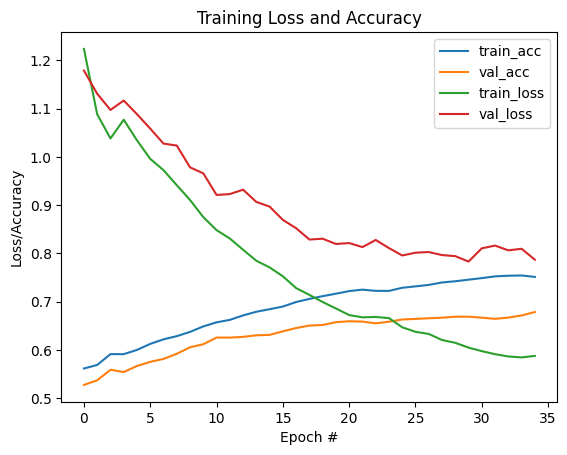

In [9]:
batch_size = 100
epochs = 50
train_ds, val_ds = tf_data(x_train, y_train, x_val, y_val,10)

es = EarlyStopping(monitor="val_loss",patience = 5,restore_best_weights=True)
H = model.fit(train_ds, callbacks = [es],epochs = epochs, verbose = 1, validation_data=val_ds)

path = "/content/drive/MyDrive/Colab Notebooks/Car_Segmentation/Unet.keras"
model.save(path)

plt.figure()
plt.plot(H.history['accuracy'], label="train_acc")
plt.plot(H.history['val_accuracy'], label="val_acc")
plt.plot(H.history['loss'], label = "train_loss")
plt.plot(H.history['val_loss'], label = "val_loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend()
plt.show()

In [8]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/Car_Segmentation/Unet.keras')

4/4 [==============================] - 1s 158ms/step


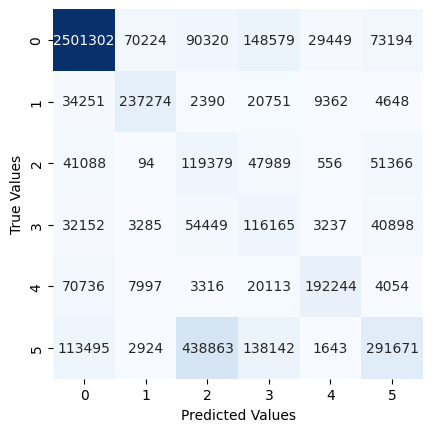

In [25]:
# Lấy dự đoán từ mô hình
y_pred = model.predict(x_test)
# Chuyển đổi dự đoán về mask
mask_pred = np.argmax(y_pred, axis=3)
mask_pred = np.array(mask_pred, dtype='float32')

# Tính toán confusion matrix
mat = confusion_matrix(y_test.flatten(), mask_pred.flatten())

# Vẽ confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

In [26]:
target_names = ['0', '1', '2', '3', '4','5']
print(classification_report(y_test.flatten(), mask_pred.flatten(), target_names=target_names))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88   2793024
           1       0.77      0.74      0.75    321798
           2       0.46      0.17      0.25    708717
           3       0.46      0.24      0.31    491739
           4       0.64      0.81      0.72    236491
           5       0.30      0.63      0.40    465831

    accuracy                           0.69   5017600
   macro avg       0.58      0.58      0.55   5017600
weighted avg       0.70      0.69      0.67   5017600



In [56]:
def preprocess_new_image(image):
    # Chuẩn hóa giá trị pixel trong khoảng [0, 1]
    normalized_image = image.astype('float32') / 255.0

    # Thay đổi kích thước hình ảnh
    resized_image = cv2.resize(normalized_image, (224, 224))

    # Chuyển đổi định dạng và kiểu dữ liệu
    processed_image = np.expand_dims(resized_image, axis=0)

    return processed_image

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/Car_Segmentation/Unet.keras')

1/1 [==============================] - 1s 893ms/step


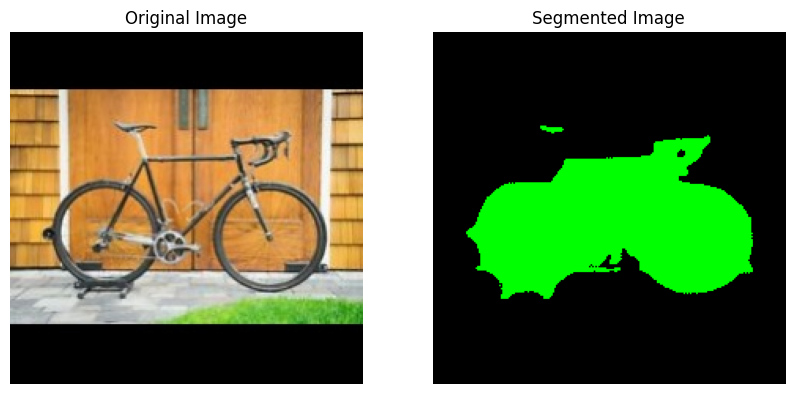

1/1 [==============================] - 1s 697ms/step


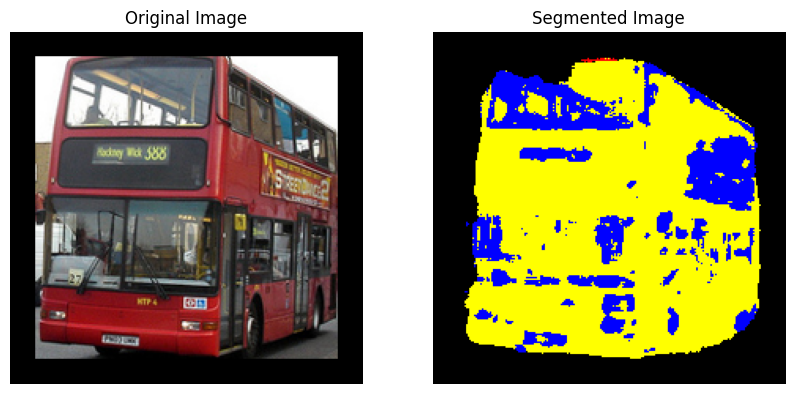

1/1 [==============================] - 1s 1s/step


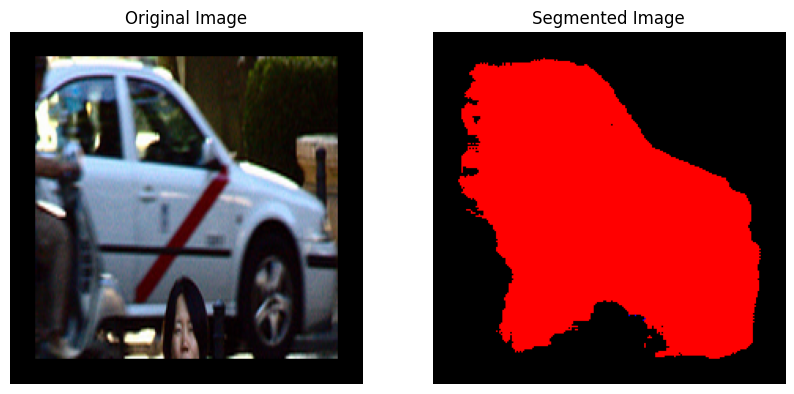

1/1 [==============================] - 0s 463ms/step


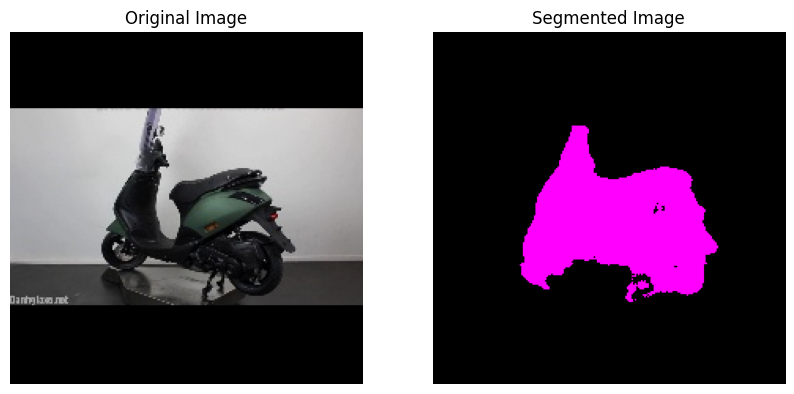

1/1 [==============================] - 0s 433ms/step


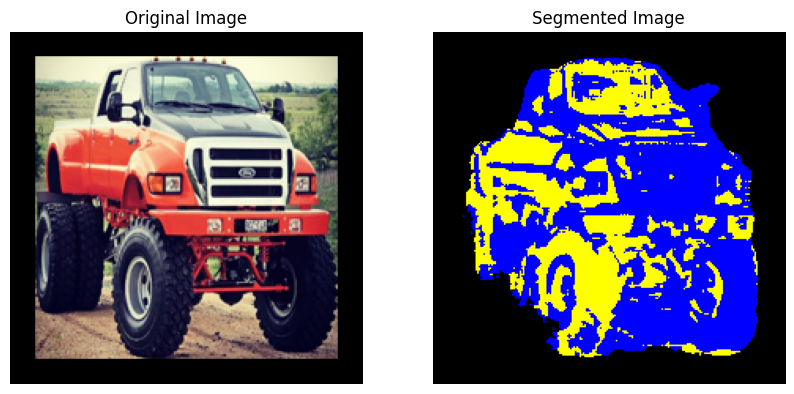

In [ ]:
anh = ['/content/drive/MyDrive/Deep/Segment_Data/Images/Bicycle/Bicycle (85).jpg',
       '/content/drive/MyDrive/Deep/Segment_Data/Images/Bus/a (85).png',
       '/content/drive/MyDrive/Deep/Segment_Data/Images/Car/car (4).png',
       '/content/drive/MyDrive/Deep/Segment_Data/Images/Moto/Moto (12).jpg',
       '/content/drive/MyDrive/Deep/Segment_Data/Images/Truck/truck (81).png']

# Lấy ảnh từ index
for path in anh:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    img = cv2.imread(path)
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].axis('off')
    axs[0].set_title('Original Image')

    # Tiền xử lý ảnh
    img = preprocess_new_image(img)
    pred = model.predict(img)

    # Dự đoán nhãn
    # Chuyển dự đoán về mask
    mask_pred = np.argmax(pred, axis=3)
    mask_pred = train_id_to_color[np.squeeze(mask_pred)]
    mask_pred = np.array(mask_pred, dtype='uint8')

    # Chuyển đổi không gian màu từ BGR sang RGB
    mask_pred_rgb = cv2.cvtColor(mask_pred, cv2.COLOR_BGR2RGB)

    # Hiển thị ảnh đã phân vùng
    axs[1].imshow(cv2.cvtColor(mask_pred_rgb, cv2.COLOR_BGR2RGB))
    axs[1].axis('off')
    axs[1].set_title('Segmented Image')

    plt.show()

1/1 [==============================] - 0s 413ms/step


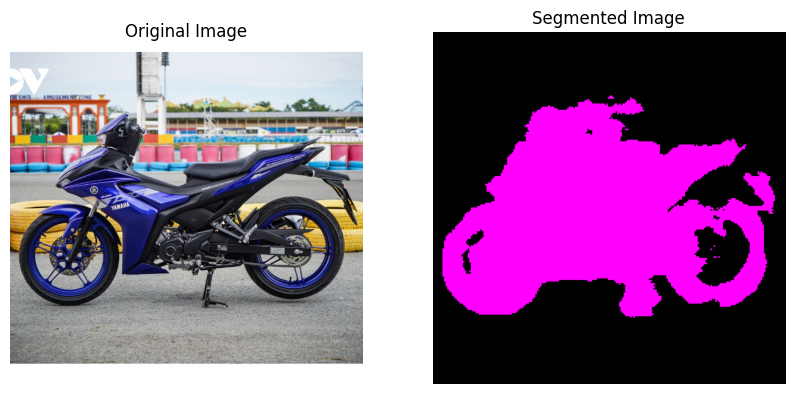

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
img = cv2.imread('/content/drive/MyDrive/exc.png')
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title('Original Image')

# Tiền xử lý ảnh
img = preprocess_new_image(img)
pred = model.predict(img)

# Dự đoán nhãn
# Chuyển dự đoán về mask
mask_pred = np.argmax(pred, axis=3)
mask_pred = train_id_to_color[np.squeeze(mask_pred)]
mask_pred = np.array(mask_pred, dtype='uint8')

# Chuyển đổi không gian màu từ BGR sang RGB
mask_pred_rgb = cv2.cvtColor(mask_pred, cv2.COLOR_BGR2RGB)

# Hiển thị ảnh đã phân vùng
axs[1].imshow(cv2.cvtColor(mask_pred_rgb, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title('Segmented Image')

plt.show()